In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import math as m
import numpy.linalg as la
import scipy.linalg as sla
import csv

#Boeing Insitu ScanEagle Numbers (ON EARTH)
g = 9.81 #m/s^2
w1 = (18+14)/2 #avg empty structure weight in kg
w0 = 22 #kg (max takeoff weight)
Vmax = 41.2 #m/s max horisontal speed
Vcruise = (30 + 25)/2 #avg cruise speed in m/s
b = 3.11 #m (wingspan)
c = 3.11/13 #m (chord length using pixel counting)
Ceiling = 5944 #m
ServiceC = 4572 #m
Sref = b*c

#Boeing Insitu ScanEagle Numbers (ON TITAN)
gt = 1.352 #m/s^2 (t = Titan)
w1t = (w1)*gt #avg empty structure weight in kg
w0t = (w0)*gt #max takeoff weight in kg



In [188]:
#read csv
temp = []
altitudes = []
with open("TitanTempAlt.csv",'r') as csvfile:
    plots = csv.reader(csvfile, dialect='excel', delimiter=',')
    for row in plots:
        try:
            altitudes.append(float(row[0]))
            temp.append(float(row[1]))
        except:
            continue
            

def atms_conditions(alt):
    #get alt in km to work with csv data which is in km
    alt = alt/1000
    if alt > altitudes[-1] or alt <= 0:
        print("sorry this altitude is not in range of our function")
        return
    
    P0 = 146700 #Pa
    R  = 296.9  #J/kg * K
    rho0 = P0 / (temp[0] * R)
    g = 1.352 #m/s^2; just googled value for titan
    #exponential relation for density
    #print(alt)
    R_titan = 2575 #km
    P1 = P0 * math.exp(-alt/(R_titan))
    #print(rho0)
    iterator = 0 #describes state state of while loop (ie what altitude and temp to be at)
    next_temp = temp[0]
    #lists akin to vectors, allow for dynamic storage of values
    while altitudes[iterator] < alt:
        #get the temp and altitude of the next state of function
        next_temp = temp[iterator + 1]
        next_altitude = altitudes[iterator + 1]
        iterator += 1
    
    T_ceil = temp[iterator]
    T_floor = temp[iterator - 1]
    alt_ceil = altitudes[iterator]
    alt_floor = altitudes[iterator - 1]
    T1 = linear_interpolator(T_floor, T_ceil, alt_floor, alt_ceil, alt)
    #print(T_floor, T_ceil, T1)
    
    rho1 = P1 / (R * T1)
    
    print(rho1)
    return alt*1000, P1, T1, rho1


In [53]:
def LiftCoeff(W, vlist, Sref, rho): 
    CL = W/(0.5*rho*vlist**2)
    return CL

5.3461317879949135
5.421060918973253
5.4879875496995805
5.55661453623884
5.617682795268945
5.6801330079051695
5.735673588001221
5.792333487037027
5.842927329776698
5.894433195456286
[40.21949979611425, 40.22036334353987, 40.22112413904503, 40.221882476701836, 40.22255403167979, 40.22322149546412, 40.22381169254502, 40.22440207385314, 40.22491908251481, 40.22544590178393]
The energies are equal at v = 38.972972972972975m/s


C:\Users\philipc2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\philipc2\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


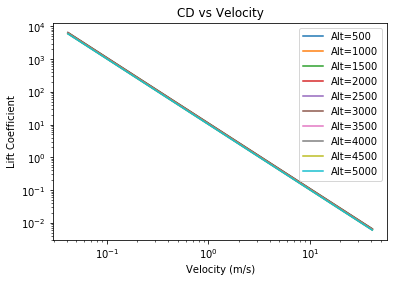

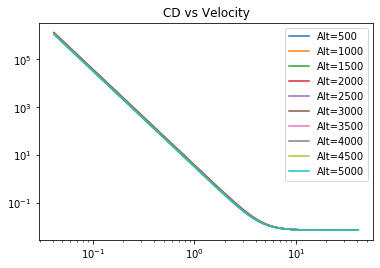

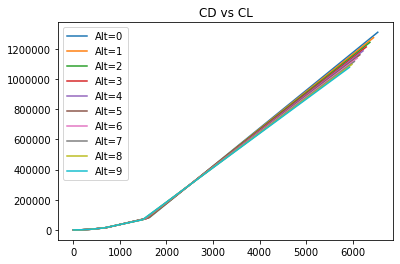

(1000,) (10, 1000)


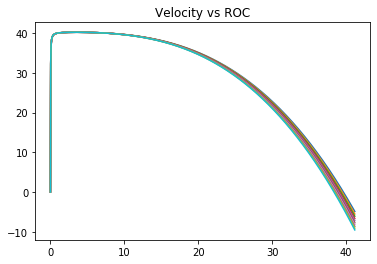

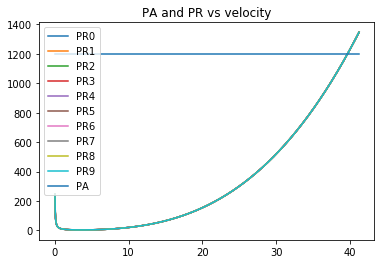

In [189]:
# INITIAL VALUES
# Data from paper on UAV's https://www.researchgate.net/publication/220024745_Estimation_of_Lift_and_Drag_Characteristics_of_UTM_Elang-1_UAV
CL_list_ppr = np.array([[-5,0,5,10,15,18],[-0.3122,0.1579,0.5974,1.0455,1.3396,1.3645]])
CD_list_ppr = np.array([[-5,0,5,10,15,18],[0.0986,0.0904,0.1087,0.1590,0.2440,0.316]])

# Least Squares fit coefficients
CL_approx_coeff = np.polyfit(CL_list_ppr[0],CL_list_ppr[1], 4)
CD_approx_coeff = np.polyfit(CD_list_ppr[0],CD_list_ppr[1], 4)

# Data for Approximation



#plt.plot(CL_list_ppr[0], CL_list_ppr[1], label='CL')
#plt.plot(CD_list_ppr[0], CD_list_ppr[1], label='CD')
#plt.legend()
#plt.show()






cd0 = 0.0072
PA = 1200 # wats
PA_list = np.linspace(1200, 1200, 1000)

# Calculate the atomospheric conditions for a range of altitudes
alt_list = np.arange(500, 5500, 500)
result_list = [atms_conditions(alt) for alt in alt_list]
result_list = np.array(result_list)
result_list

# Calculate CL for all the values of rho
vlist = np.linspace(0, Vmax, 1000)
CL_list = [LiftCoeff(w0t, vlist, Sref, result_list[i, 3]) for i in range(np.shape(result_list)[0])]

# Calculate CD for all the values of CL
CD_list = [cd0 + CL**2/(np.pi*0.8*13.) for CL in CL_list]

CL_list = np.array(CL_list)
CD_list = np.array(CD_list)

# Calculate Thrsut Required
TR_list = [w0t/(CL_list[i,:]/CD_list[i,:]) for i in range(np.shape(result_list)[0])]
TR_list = np.array(TR_list)

# Calculate Power Required
PR_list = [TR * vlist for TR in TR_list]
PR_list = np.array(PR_list)

# Calculate Rate of Climb
ROC_list = [(PA - PR) / w0t for PR in PR_list]
ROC_list = np.array(ROC_list)
ROC_list[:, 0] = 0 #Remove the point [0, infinity]                                        

# Calculate max ROC
ROC_MAX_list = []
for i in range(np.shape(ROC_list)[0]):
    ROC_MAX_list.append(np.max(ROC_list[i, :]))
    
print(ROC_MAX_list)
    


# Find Energy Intersections: PA = PR
P_EQUAL_indexes = []
for i in range(np.shape(ROC_list)[0]):
    for j in range(np.shape(ROC_list)[1]):
        if (PR_list[i, j] >= PA):
            P_EQUAL_indexes.append(j)
            break;
P_EQUAL_indexes = np.array(P_EQUAL_indexes)

P_EQUAL_index_avg = int(np.mean(P_EQUAL_indexes))
print("The energies are equal at v = {}m/s".format(vlist[P_EQUAL_index_avg]))



########## ALL PLOTTING FROM THIS POINT ONWARDS



plt.yscale('log')
plt.xscale('log')
plt.title("Lift Coefficient vs Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Lift Coefficient")

i = 500
for CL in CL_list:
    plt.plot(vlist, CL, label="Alt={}".format(i))
    i+=500
    
plt.title("CD vs Velocity")
plt.legend()
plt.show()

i = 500
for CD in CD_list:
    plt.plot(vlist, CD, label="Alt={}".format(i))
    i+=500
plt.yscale('log')
plt.xscale('log')
plt.title("CD vs Velocity")
plt.legend()
plt.show()

for i in range(np.shape(CL_list)[0]):
    plt.plot(CL_list[i], CD_list[i], label="Alt={}".format(i))

plt.title("CD vs CL")
plt.legend()
plt.show()

print(np.shape(vlist), np.shape(ROC_list))

for i in range(np.shape(ROC_list)[0]):
    plt.plot(vlist, ROC_list[i, :])
plt.title("Velocity vs ROC")
plt.show()

for i in range(np.shape(PR_list)[0]):
    plt.plot(vlist, PR_list[0], label = 'PR{}'.format(i))
plt.plot(vlist, PA_list, label = 'PA')
plt.title("PA and PR vs velocity")
plt.legend()
plt.show()



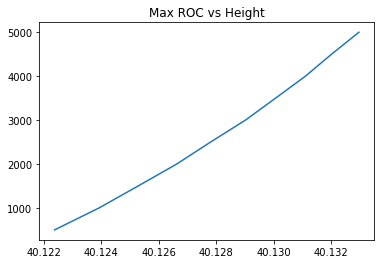

In [185]:
plt.plot(ROC_MAX_list, alt_list)
plt.title("Max ROC vs Height")
plt.show()

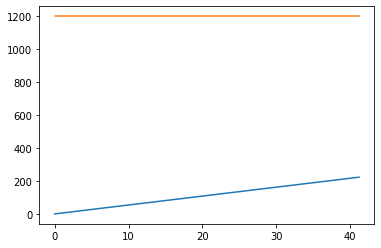

In [179]:
CL_list_ppr[1, 4]

TR_x = w0t / (CL_list_ppr[1, 2]/CD_list_ppr[1, 2])
PR_x = TR_x * vlist
ROC_x = (PA - PR_x) / (w0t)

plt.plot(vlist, PR_x)
plt.plot(vlist, PA_list)
